# LSTM Model for EMG to Finger Position Prediction

This notebook trains an LSTM model to predict finger positions from EMG sensor data.

## Pipeline Overview:

1. Load and clean data
1. Create temporal sequences
1. Split into train/test sets (80/20)
1. Train LSTM model with proper batching
1. Evaluate on unseen test data
1. Visualize predictions

## 1. Import Libraries

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.9.0+cpu
Device: CPU


## 2. Load and Clean Data

Load CSV data and handle corrupted rows where sensor values are missing or misaligned.

In [3]:
# Load data
path = os.path.join("../../data", "integrated_data_20251104_192229.csv")
df = pd.read_csv(path)

print("="*60)
print("RAW DATA INFO")
print("="*60)
print(f"Original shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 3 rows:\n{df.head(3)}")

# Define required numeric columns (excluding timestamp and hand_label)
numeric_columns = ['iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 
                   'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']

# Convert all numeric columns, coercing errors to NaN (handles corrupted rows)
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove rows with any NaN values in numeric columns
df_clean = df.dropna(subset=numeric_columns)

print(f"\nRows removed (corrupted/missing data): {len(df) - len(df_clean)}")
print(f"Clean data shape: {df_clean.shape}")

# Extract only numeric data (drop timestamp and hand_label)
data = df_clean[numeric_columns].values.astype(np.float32)

print(f"\nFinal numeric data shape: {data.shape}")
print(f"Data statistics:\n{pd.DataFrame(data, columns=numeric_columns).describe()}")

RAW DATA INFO
Original shape: (4067, 17)
Columns: ['timestamp', 'iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky', 'hand_label']

First 3 rows:
                    timestamp  iteration   env0  raw0   env1   raw1   env2  \
0  2025-11-04T19:22:43.330889          0  495.0  37.0  500.0  475.0  492.0   
1  2025-11-04T19:22:43.469210          1  493.0  66.0  490.0  472.0  496.0   
2  2025-11-04T19:22:43.594276          2  494.0  54.0  498.0  336.0  491.0   

    raw2   env3 raw3 thumb_tip thumb_base   index  middle    ring   pinky  \
0   95.0   96.0   17    0.9930     0.5480  0.7131  0.7356  0.7170  0.6750   
1  110.0  104.0   18    0.9308     0.5457  0.7131  0.7503  0.7170  0.6839   
2   88.0  104.0   17    0.9204     0.5727  0.7185  0.7824  0.7358  0.6565   

  hand_label  
0       Left  
1       Left  
2       Left  

Rows removed (corrupted/missing data): 252
Clean data shape: (3815, 17)

Final numer

## 3. Prepare Data for LSTM

Separate sensor inputs from finger outputs and create temporal sequences.

In [4]:
# Define sensor (input) and finger (output) columns
sensor_columns = ['env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3']
finger_columns = ['thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']

# Get column indices in the data array
sensor_indices = [numeric_columns.index(col) for col in sensor_columns]
finger_indices = [numeric_columns.index(col) for col in finger_columns]

print("="*60)
print("DATA CONFIGURATION")
print("="*60)
print(f"Sensor columns (inputs): {sensor_columns}")
print(f"Sensor indices: {sensor_indices}")
print(f"Number of input features: {len(sensor_indices)}")
print(f"\nFinger columns (outputs): {finger_columns}")
print(f"Finger indices: {finger_indices}")
print(f"Number of output features: {len(finger_indices)}")

DATA CONFIGURATION
Sensor columns (inputs): ['env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3']
Sensor indices: [1, 2, 3, 4, 5, 6, 7, 8]
Number of input features: 8

Finger columns (outputs): ['thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']
Finger indices: [9, 10, 11, 12, 13, 14]
Number of output features: 6


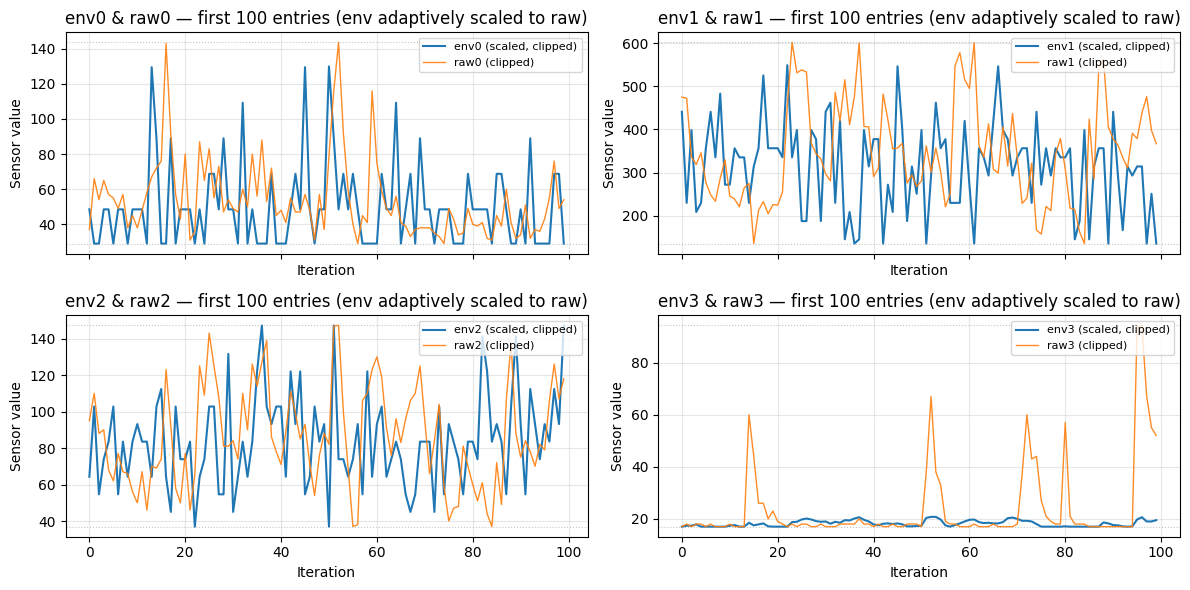

Saved sensors plot to: ..\..\models\sensors_100_iterations_clipped_scaled_env.png


In [ ]:
# ...existing code...
# Plot first 100 iterations for the four sensors (env/raw pairs) with outlier capping
import os
import numpy as np
import matplotlib.pyplot as plt

# choose source dataframe
if 'df_clean' in globals():
    src = df_clean
else:
    src = pd.DataFrame(data, columns=numeric_columns)

# window length (100 iterations)
n = min(100, len(src))
window = src.iloc[:n].copy()

# Outlier capping: percentiles to use (1..99 by default)
p_low, p_high = 1.0, 99.0

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
axes = axes.flatten()

sensor_pairs = [('env0','raw0'), ('env1','raw1'), ('env2','raw2'), ('env3','raw3')]

for i, (env_col, raw_col) in enumerate(sensor_pairs):
    ax = axes[i]

    # compute per-column clip bounds using percentiles (robust to outliers)
    env_vals = window[env_col].values.astype(float)
    raw_vals = window[raw_col].values.astype(float)
    env_lo, env_hi = np.percentile(env_vals, [p_low, p_high])
    raw_lo, raw_hi = np.percentile(raw_vals, [p_low, p_high])

    # create clipped series for plotting (does not modify original dataframe)
    env_plot = np.clip(env_vals, env_lo, env_hi)
    raw_plot = np.clip(raw_vals, raw_lo, raw_hi)

    # --- Adaptive scaling: match env to raw robustly ---
    # Use IQR ratio primarily, fallback to std ratio, then to 1. Avoid divide-by-zero.
    def robust_scale(src_arr, tgt_arr):
        q1s, q3s = np.percentile(src_arr, [25,75])
        q1t, q3t = np.percentile(tgt_arr, [25,75])
        iqr_s = q3s - q1s
        iqr_t = q3t - q1t
        if iqr_s > 1e-6:
            scale = iqr_t / iqr_s
        else:
            # fallback to std
            std_s = np.std(src_arr)
            std_t = np.std(tgt_arr)
            scale = (std_t / std_s) if std_s > 1e-6 else 1.0
        # center to medians
        med_s = np.median(src_arr)
        med_t = np.median(tgt_arr)
        return scale, med_s, med_t

    scale, med_env, med_raw = robust_scale(env_plot, raw_plot)
    env_scaled = (env_plot - med_env) * scale + med_raw

    # Re-clip scaled env to raw clipping bounds for plotting clarity
    env_scaled = np.clip(env_scaled, raw_lo, raw_hi)

    ax.plot(env_scaled, label=f'{env_col} (scaled, clipped)', color='tab:blue', linewidth=1.5)
    ax.plot(raw_plot, label=f'{raw_col} (clipped)', color='tab:orange', linewidth=1.0, alpha=0.9)

    # show clip thresholds as thin dashed lines for context (use raw thresholds)
    ax.axhline(raw_lo, color='tab:gray', linestyle=':', linewidth=0.8, alpha=0.45)
    ax.axhline(raw_hi, color='tab:gray', linestyle=':', linewidth=0.8, alpha=0.45)

    ax.set_title(f'{env_col} & {raw_col} — first {n} entries (env adaptively scaled to raw)')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Sensor value')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
out_dir = os.path.join('..','..','models')
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'sensors_100_iterations_clipped_scaled_env.png')
plt.savefig(out_path, dpi=200, bbox_inches='tight')
plt.show()
print(f'Saved sensors plot to: {out_path}')


## 4. Create Temporal Sequences

LSTMs need sequences of data. We'll create sliding windows of sensor readings to predict the next finger position.

In [36]:
def create_sequences(data, seq_length):
    """
    Create sequences for LSTM training.
    
    Args:
        data: numpy array of shape (num_samples, num_features)
        seq_length: length of input sequence
    
    Returns:
        X: sequences of shape (num_sequences, seq_length, num_features)
        y: targets of shape (num_sequences, num_features)
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length, :]  # Sequence of seq_length time steps
        y = data[i + seq_length, :]    # Next time step (target)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create sequences
seq_length = 15
X, y = create_sequences(data, seq_length)

print(f"\nSequence length: {seq_length} time steps")
print(f"Total sequences created: {len(X)}")
print(f"X shape: {X.shape} (num_sequences, seq_length, num_features)")
print(f"y shape: {y.shape} (num_sequences, num_features)")


Sequence length: 15 time steps
Total sequences created: 3800
X shape: (3800, 15, 15) (num_sequences, seq_length, num_features)
y shape: (3800, 15) (num_sequences, num_features)


## 5. Train/Test Split and Feature Selection

Split data temporally (80/20) and separate sensor inputs from finger outputs.

In [37]:
# Split data temporally (80% train, 20% test)
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("="*60)
print("TRAIN/TEST SPLIT")
print("="*60)
print(f"Total sequences: {len(X)}")
print(f"Training sequences: {len(X_train)} ({split_ratio*100:.0f}%)")
print(f"Testing sequences: {len(X_test)} ({(1-split_ratio)*100:.0f}%)")

# Extract sensor and finger features
trainX = torch.tensor(X_train[:, :, sensor_indices], dtype=torch.float32)
trainY = torch.tensor(y_train[:, finger_indices], dtype=torch.float32)
testX = torch.tensor(X_test[:, :, sensor_indices], dtype=torch.float32)
testY = torch.tensor(y_test[:, finger_indices], dtype=torch.float32)

print(f"\nTraining data:")
print(f"  trainX: {trainX.shape} (sequences, seq_length, input_features)")
print(f"  trainY: {trainY.shape} (sequences, output_features)")
print(f"\nTesting data:")
print(f"  testX: {testX.shape}")
print(f"  testY: {testY.shape}")

print(f"\nInput features: {len(sensor_indices)}")
print(f"Output features: {len(finger_indices)}")

TRAIN/TEST SPLIT
Total sequences: 3800
Training sequences: 3040 (80%)
Testing sequences: 760 (20%)

Training data:
  trainX: torch.Size([3040, 15, 8]) (sequences, seq_length, input_features)
  trainY: torch.Size([3040, 6]) (sequences, output_features)

Testing data:
  testX: torch.Size([760, 15, 8])
  testY: torch.Size([760, 6])

Input features: 8
Output features: 6


## 6. Normalize Data

Normalize inputs and outputs for better training stability.

In [38]:
# Normalize sensor data (inputs)
scaler_X = StandardScaler()
trainX_reshaped = trainX.reshape(-1, trainX.shape[-1]).numpy()
trainX_scaled = scaler_X.fit_transform(trainX_reshaped).reshape(trainX.shape)
trainX = torch.tensor(trainX_scaled, dtype=torch.float32)

testX_reshaped = testX.reshape(-1, testX.shape[-1]).numpy()
testX_scaled = scaler_X.transform(testX_reshaped).reshape(testX.shape)
testX = torch.tensor(testX_scaled, dtype=torch.float32)

# Normalize finger data (outputs)
scaler_Y = StandardScaler()
trainY_scaled = scaler_Y.fit_transform(trainY.numpy())
trainY = torch.tensor(trainY_scaled, dtype=torch.float32)

testY_scaled = scaler_Y.transform(testY.numpy())
testY = torch.tensor(testY_scaled, dtype=torch.float32)

print("✓ Data normalized using StandardScaler")
print(f"  Sensor mean: {scaler_X.mean_[:3].round(2)} (first 3 features)")
print(f"  Sensor std: {scaler_X.scale_[:3].round(2)} (first 3 features)")
print(f"  Finger mean: {scaler_Y.mean_[:3].round(2)} (first 3 features)")
print(f"  Finger std: {scaler_Y.scale_[:3].round(2)} (first 3 features)")

✓ Data normalized using StandardScaler
  Sensor mean: [494.62  51.57 495.98] (first 3 features)
  Sensor std: [  1.62 262.01 111.29] (first 3 features)
  Finger mean: [0.66 0.34 0.46] (first 3 features)
  Finger std: [0.39 0.29 0.34] (first 3 features)


## 7. Define LSTM Model

In [39]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout=0.2):
        """
        LSTM model for sequence prediction.
        
        Args:
            input_dim: Number of input features
            hidden_dim: Number of hidden units in LSTM
            layer_dim: Number of LSTM layers
            output_dim: Number of output features
            dropout: Dropout probability for regularization
        """
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        # LSTM layer with dropout between layers
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            layer_dim, 
            batch_first=True,
            dropout=dropout if layer_dim > 1 else 0
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden and cell states (set to zeros)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        # LSTM forward pass
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Take the last time step output
        out = out[:, -1, :]
        
        # Apply dropout
        out = self.dropout(out)
        
        # Fully connected layer
        out = self.fc(out)
        
        return out

# Model hyperparameters
input_dim = len(sensor_indices)  # Number of sensor features
hidden_dim = 128                  # Number of hidden units
layer_dim = 2                     # Number of LSTM layers
output_dim = len(finger_indices)  # Number of finger features
dropout = 0.2                     # Dropout probability

# Initialize model
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, dropout)

print("="*60)
print("MODEL ARCHITECTURE")
print("="*60)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

MODEL ARCHITECTURE
LSTMModel(
  (lstm): LSTM(8, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

Total parameters: 203,526
Trainable parameters: 203,526


## 8. Setup Training

In [40]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=10, 
)

# Create DataLoader for batching
batch_size = 32
train_dataset = TensorDataset(trainX, trainY)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("="*60)
print("TRAINING CONFIGURATION")
print("="*60)
print(f"Loss function: MSELoss")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience=10)")
print(f"Batch size: {batch_size}")
print(f"Batches per epoch: {len(train_loader)}")

TRAINING CONFIGURATION
Loss function: MSELoss
Optimizer: Adam (lr=0.001)
Scheduler: ReduceLROnPlateau (factor=0.5, patience=10)
Batch size: 32
Batches per epoch: 95

TRAINING CONFIGURATION
Loss function: MSELoss
Optimizer: Adam (lr=0.001)
Scheduler: ReduceLROnPlateau (factor=0.5, patience=10)
Batch size: 32
Batches per epoch: 95


## 9. Train Model

Train with proper batching, validation tracking, and early stopping.

In [41]:
num_epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 200
patience_counter = 0

print("="*60)
print("TRAINING STARTED")
print("="*60)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0
    
    for batch_X, batch_Y in train_loader:
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X)
        
        # Compute loss
        loss = criterion(outputs, batch_Y)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Average training loss
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(testX)
        val_loss = criterion(val_outputs, testY)
        val_losses.append(val_loss.item())
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping check
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), "../../models/best_lstm_model.pth")
    else:
        patience_counter += 1
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {val_loss.item():.4f}, '
              f'Best Val: {best_val_loss:.4f}')
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        print(f"Best validation loss: {best_val_loss:.4f}")
        break

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")

# Load best model
model.load_state_dict(torch.load("../../models/best_lstm_model.pth"))
print("\n✓ Best model loaded")

TRAINING STARTED

TRAINING STARTED
Epoch [10/100], Train Loss: 0.9143, Val Loss: 0.8253, Best Val: 0.7787
Epoch [10/100], Train Loss: 0.9143, Val Loss: 0.8253, Best Val: 0.7787
Epoch [20/100], Train Loss: 0.7931, Val Loss: 0.9147, Best Val: 0.7787
Epoch [20/100], Train Loss: 0.7931, Val Loss: 0.9147, Best Val: 0.7787
Epoch [30/100], Train Loss: 0.6426, Val Loss: 1.0615, Best Val: 0.7787
Epoch [30/100], Train Loss: 0.6426, Val Loss: 1.0615, Best Val: 0.7787
Epoch [40/100], Train Loss: 0.5497, Val Loss: 1.0862, Best Val: 0.7787
Epoch [40/100], Train Loss: 0.5497, Val Loss: 1.0862, Best Val: 0.7787
Epoch [50/100], Train Loss: 0.4957, Val Loss: 1.1503, Best Val: 0.7787
Epoch [50/100], Train Loss: 0.4957, Val Loss: 1.1503, Best Val: 0.7787
Epoch [60/100], Train Loss: 0.4667, Val Loss: 1.1431, Best Val: 0.7787
Epoch [60/100], Train Loss: 0.4667, Val Loss: 1.1431, Best Val: 0.7787
Epoch [70/100], Train Loss: 0.4577, Val Loss: 1.1673, Best Val: 0.7787
Epoch [70/100], Train Loss: 0.4577, Val Lo

## 10. Plot Training History

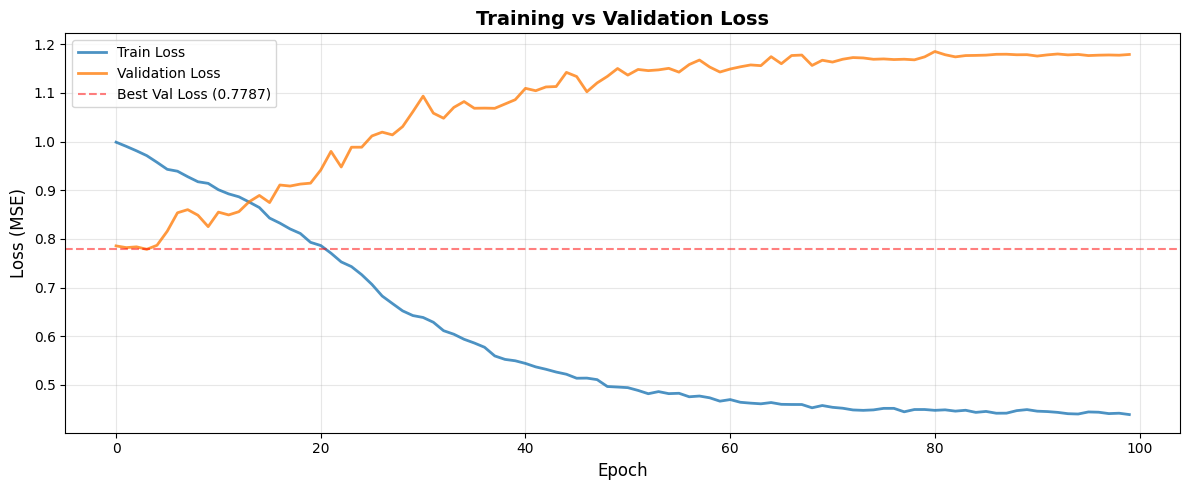

⚠ Warning: Possible overfitting detected (gap: 0.7400)


In [42]:
plt.figure(figsize=(12, 5))

plt.plot(train_losses, label='Train Loss', alpha=0.8, linewidth=2)
plt.plot(val_losses, label='Validation Loss', alpha=0.8, linewidth=2)
plt.axhline(y=best_val_loss, color='r', linestyle='--', label=f'Best Val Loss ({best_val_loss:.4f})', alpha=0.5)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check for overfitting
final_gap = val_losses[-1] - train_losses[-1]
if final_gap > 0.1:
    print(f"⚠ Warning: Possible overfitting detected (gap: {final_gap:.4f})")
else:
    print(f"✓ Good generalization (train-val gap: {final_gap:.4f})")

## 11. Evaluate on Test Set

In [43]:
# Generate predictions on test set
model.eval()
with torch.no_grad():
    predictions_scaled = model(testX).numpy()
    actual_scaled = testY.numpy()

# Inverse transform to original scale
predictions = scaler_Y.inverse_transform(predictions_scaled)
actual = scaler_Y.inverse_transform(actual_scaled)

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("="*60)
print("TEST SET EVALUATION (Per Finger)")
print("="*60)
print(f"{'Finger':<15} {'MAE':<10} {'RMSE':<10} {'R²':<10}")
print("-"*60)

for i, finger in enumerate(finger_columns):
    mae = mean_absolute_error(actual[:, i], predictions[:, i])
    rmse = np.sqrt(mean_squared_error(actual[:, i], predictions[:, i]))
    r2 = r2_score(actual[:, i], predictions[:, i])
    print(f"{finger:<15} {mae:<10.4f} {rmse:<10.4f} {r2:<10.4f}")

# Overall metrics
overall_mae = mean_absolute_error(actual, predictions)
overall_rmse = np.sqrt(mean_squared_error(actual, predictions))
overall_r2 = r2_score(actual.flatten(), predictions.flatten())

print("-"*60)
print(f"{'OVERALL':<15} {overall_mae:<10.4f} {overall_rmse:<10.4f} {overall_r2:<10.4f}")
print("="*60)

TEST SET EVALUATION (Per Finger)
Finger          MAE        RMSE       R²        
------------------------------------------------------------
thumb_tip       0.3031     0.3554     -0.0051   
thumb_base      0.1927     0.2291     -0.0615   
index           0.2546     0.2889     -0.0038   
middle          0.2558     0.2958     -0.0067   
ring            0.2502     0.2809     -0.0213   
pinky           0.2181     0.2659     0.0160    
------------------------------------------------------------
OVERALL         0.2457     0.2885     0.1202    


## 12. Visualize Predictions

Plot predicted vs actual finger positions on test set.

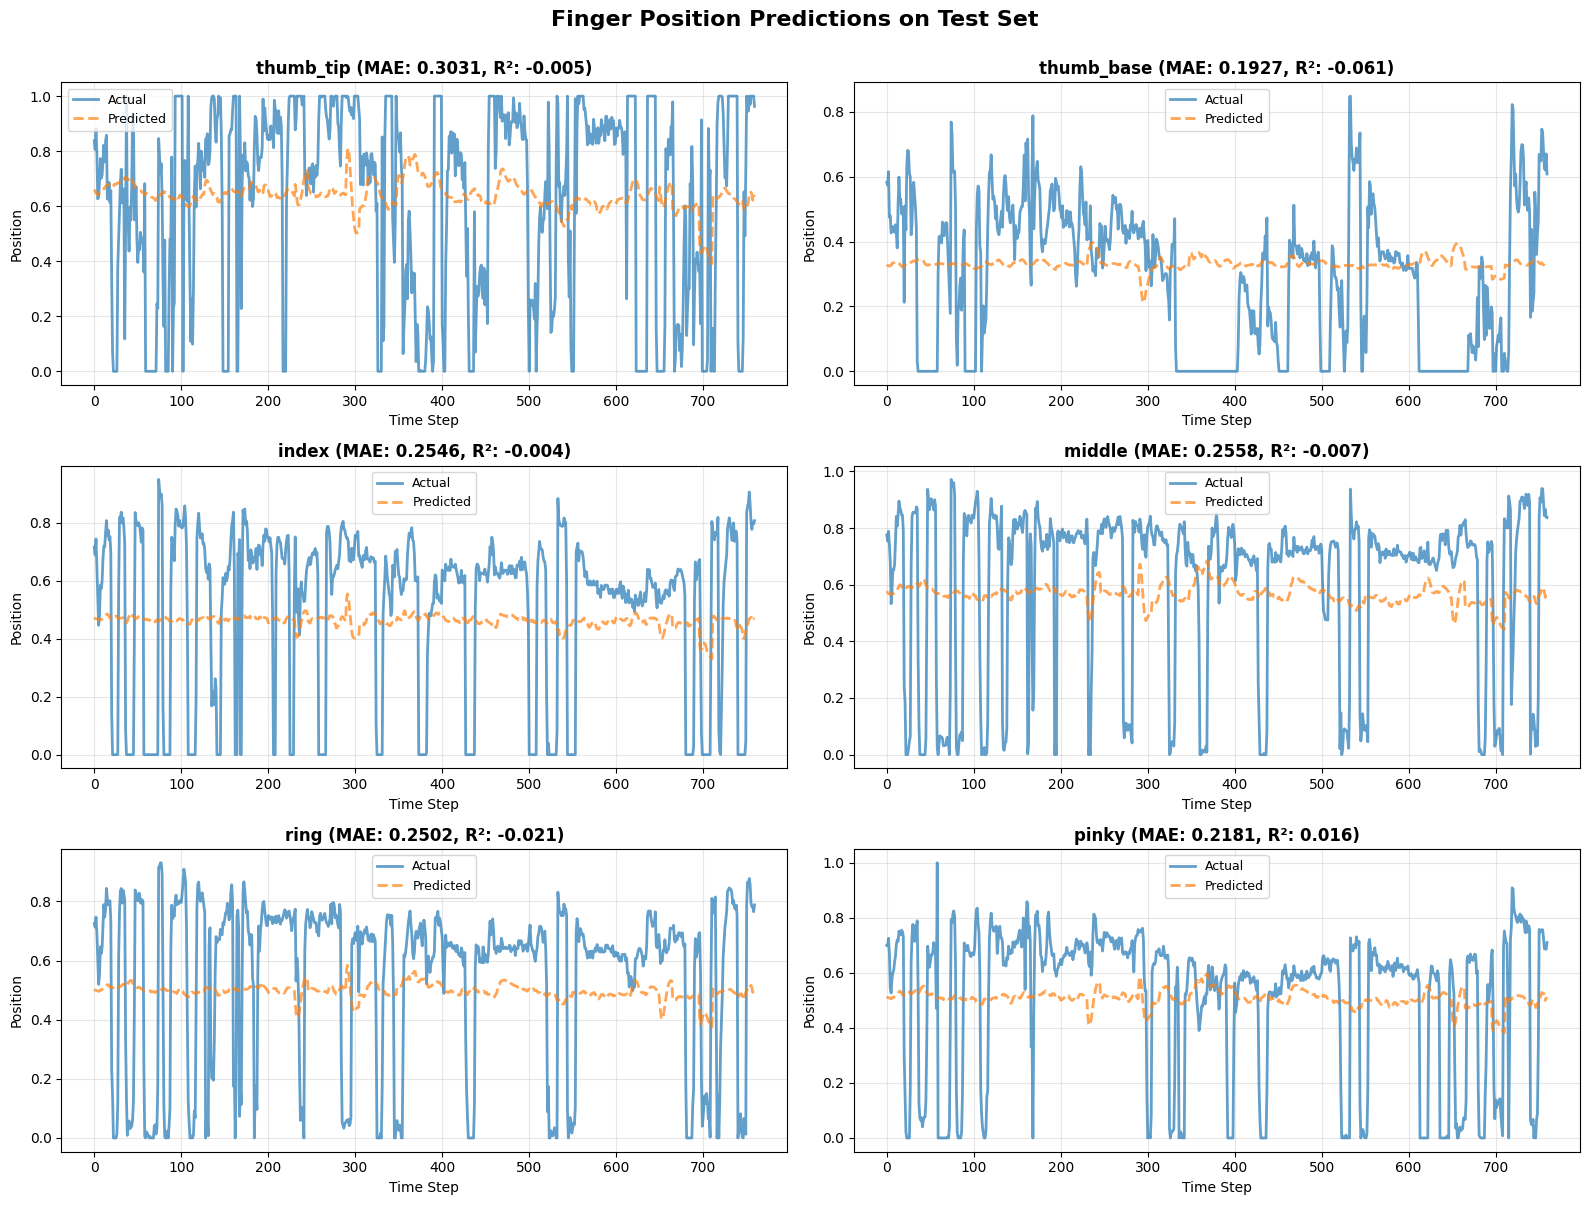

In [44]:
# Plot predictions for each finger
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, finger in enumerate(finger_columns):
    ax = axes[i]
    
    # Plot actual and predicted
    ax.plot(actual[:, i], label='Actual', alpha=0.7, linewidth=2)
    ax.plot(predictions[:, i], label='Predicted', linestyle='--', alpha=0.7, linewidth=2)
    
    # Calculate metrics for this finger
    mae = mean_absolute_error(actual[:, i], predictions[:, i])
    r2 = r2_score(actual[:, i], predictions[:, i])
    
    ax.set_title(f'{finger} (MAE: {mae:.4f}, R²: {r2:.3f})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time Step', fontsize=10)
    ax.set_ylabel('Position', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Finger Position Predictions on Test Set', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 13. Scatter Plots (Predicted vs Actual)

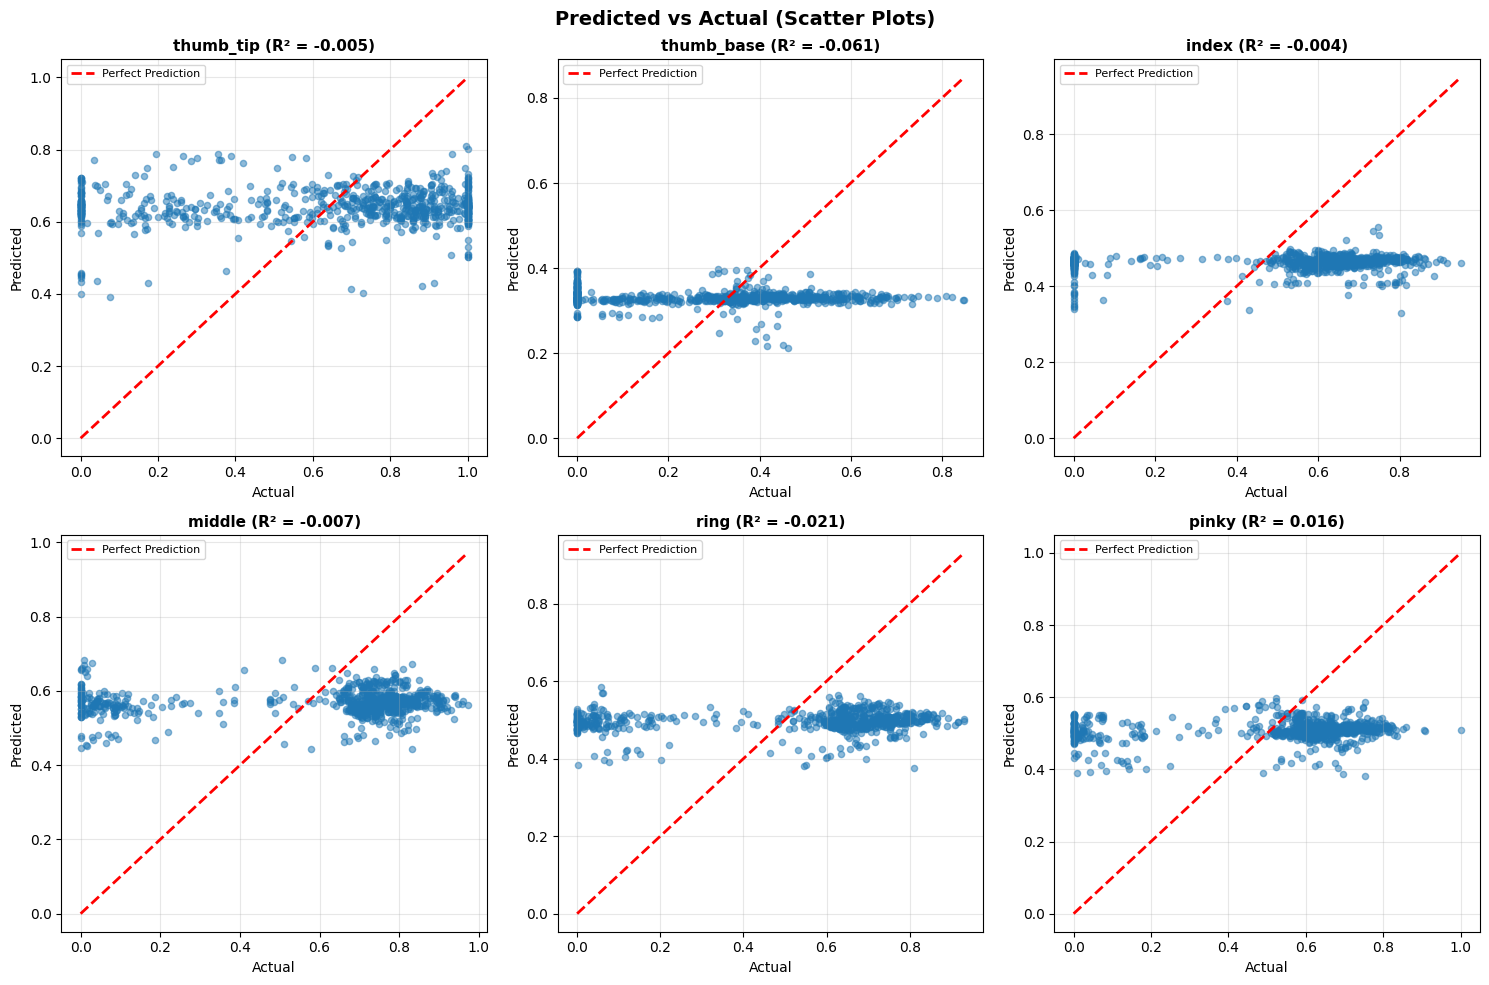

In [45]:
# Scatter plots to visualize prediction accuracy
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, finger in enumerate(finger_columns):
    ax = axes[i]
    
    # Scatter plot
    ax.scatter(actual[:, i], predictions[:, i], alpha=0.5, s=20)
    
    # Perfect prediction line
    min_val = min(actual[:, i].min(), predictions[:, i].min())
    max_val = max(actual[:, i].max(), predictions[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Calculate R²
    r2 = r2_score(actual[:, i], predictions[:, i])
    
    ax.set_xlabel('Actual', fontsize=10)
    ax.set_ylabel('Predicted', fontsize=10)
    ax.set_title(f'{finger} (R² = {r2:.3f})', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Predicted vs Actual (Scatter Plots)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 14. Save Final Model

In [46]:
# Save model and scalers
model_save_path = "../../models/lstm_model_final.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler_X_mean': scaler_X.mean_,
    'scaler_X_scale': scaler_X.scale_,
    'scaler_Y_mean': scaler_Y.mean_,
    'scaler_Y_scale': scaler_Y.scale_,
    'input_dim': input_dim,
    'hidden_dim': hidden_dim,
    'layer_dim': layer_dim,
    'output_dim': output_dim,
    'seq_length': seq_length,
    'sensor_columns': sensor_columns,
    'finger_columns': finger_columns
}, model_save_path)

print("="*60)
print("MODEL SAVED")
print("="*60)
print(f"Model saved to: {model_save_path}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Overall test R²: {overall_r2:.4f}")
print("\n✓ Training complete!")

MODEL SAVED
Model saved to: ../../models/lstm_model_final.pth
Best validation loss: 0.7787
Overall test R²: 0.1202

✓ Training complete!



PER-FINGER PARAM SEARCH FOR NON-LINEAR MAPPING
thumb_tip    chosen a=0.300, b=1.500 -> MAE=0.4114, RMSE=0.4670, R²=-0.1216
thumb_base   chosen a=1.500, b=1.500 -> MAE=0.4313, RMSE=0.4675, R²=-0.0941
index        chosen a=0.300, b=1.500 -> MAE=0.4037, RMSE=0.4481, R²=-0.0986
middle       chosen a=0.300, b=1.500 -> MAE=0.4174, RMSE=0.4664, R²=-0.2425
ring         chosen a=0.300, b=1.500 -> MAE=0.4189, RMSE=0.4662, R²=-0.2083
pinky        chosen a=0.300, b=1.500 -> MAE=0.4064, RMSE=0.4569, R²=-0.1726
------------------------------------------------------------------------
OVERALL mapped MAE=0.4149 RMSE=0.4621 R²=-0.1043



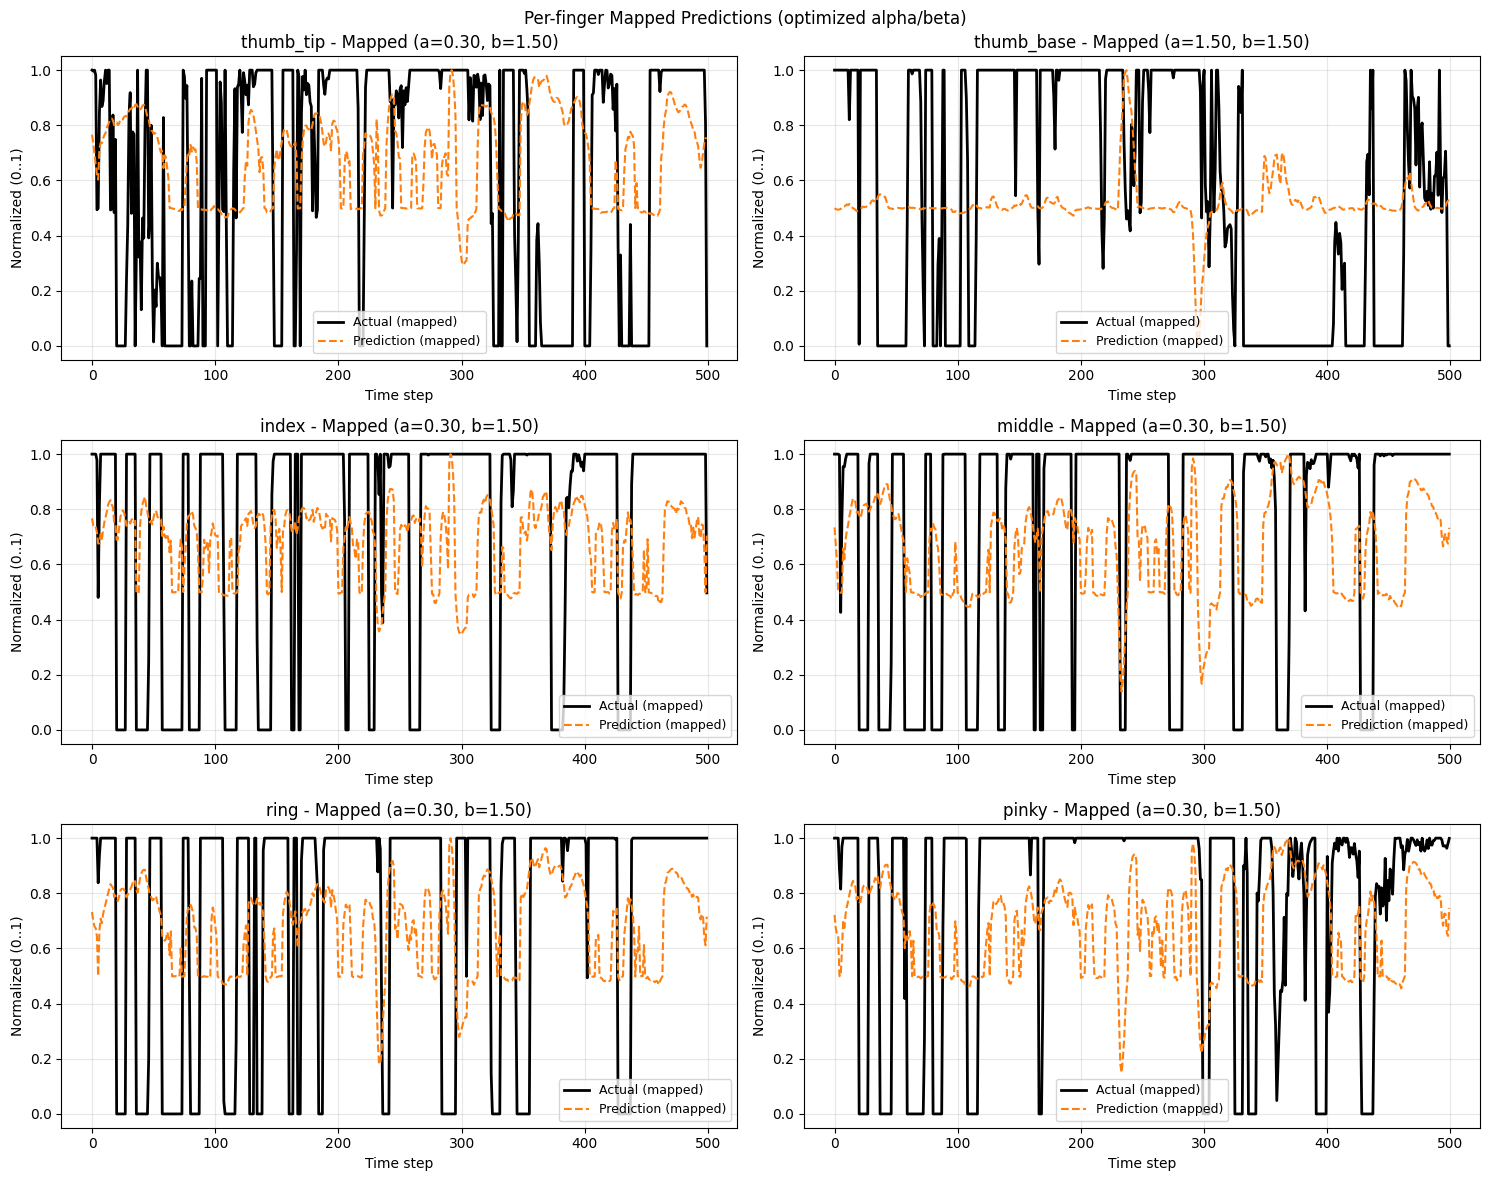

Saved per-finger mapped plot to: ..\..\models\predictions_mapped_per_finger_opt.png


In [48]:
# --- Per-finger non-linear mapping with per-finger parameter search
# For each finger: find (alpha,beta) that best maps predictions to actual on [0,1]
# using the prediction baseline (mean/min/max). This guarantees min->0, mean->0.5, max->1

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Base predictions (prefer corrected) and actual
if 'predictions_corrected' in globals():
    base_preds = np.asarray(predictions_corrected)
    base_label = 'Corrected Prediction'
else:
    base_preds = np.asarray(predictions)
    base_label = 'Prediction'
actual = np.asarray(actual)

n_samples, n_fingers = base_preds.shape

# Grid for alpha (positives) and beta (negatives). Values <1 accentuate extremes, >1 compress.
alpha_grid = np.array([0.3, 0.5, 0.7, 1.0, 1.5])
beta_grid  = np.array([0.3, 0.5, 0.7, 1.0, 1.5])

# Containers for final mapped signals and chosen params
amapped_preds = np.zeros_like(base_preds)
amapped_actual = np.zeros_like(actual)
chosen_params = []

# Mapping helper
def map_series(x, m, mn, mx, a, b):
    denom_pos = mx - m if mx - m > 0 else 1.0
    denom_neg = m - mn if m - mn > 0 else 1.0
    above_mask = x >= m
    mapped = np.empty_like(x, dtype=float)
    # normalized distances 0..1
    pos_norm = np.zeros_like(x, dtype=float)
    neg_norm = np.zeros_like(x, dtype=float)
    pos_norm[above_mask] = (x[above_mask] - m) / denom_pos
    neg_norm[~above_mask] = (m - x[~above_mask]) / denom_neg
    pos_mapped = 0.5 + 0.5 * np.power(np.clip(pos_norm, 0.0, 1.0), a)
    neg_mapped = 0.5 - 0.5 * np.power(np.clip(neg_norm, 0.0, 1.0), b)
    mapped[above_mask] = pos_mapped[above_mask]
    mapped[~above_mask] = neg_mapped[~above_mask]
    return np.clip(mapped, 0.0, 1.0)

print('\n' + '='*72)
print('PER-FINGER PARAM SEARCH FOR NON-LINEAR MAPPING')
print('='*72)

for i, finger in enumerate(finger_columns):
    x = base_preds[:, i]
    y = actual[:, i]
    m = np.mean(x)
    mn = np.min(x)
    mx = np.max(x)

    best_mae = float('inf')
    best_a, best_b = alpha_grid[0], beta_grid[0]
    best_mapped_pred = None
    best_mapped_act = None

    # grid search: choose alpha,beta minimizing MAE between mapped actual and mapped preds
    for a in alpha_grid:
        for b in beta_grid:
            mapped_pred = map_series(x, m, mn, mx, a, b)
            # apply same mapping parameters to actual (so comparisons are consistent)
            mapped_act = map_series(y, m, mn, mx, a, b)
            mae = mean_absolute_error(mapped_act, mapped_pred)
            if mae < best_mae:
                best_mae = mae
                best_a, best_b = a, b
                best_mapped_pred = mapped_pred
                best_mapped_act = mapped_act

    # store results
    amapped_preds[:, i] = best_mapped_pred
    amapped_actual[:, i] = best_mapped_act
    chosen_params.append((best_a, best_b))

    # metrics for selected mapping
    rmse = np.sqrt(mean_squared_error(best_mapped_act, best_mapped_pred))
    r2 = r2_score(best_mapped_act, best_mapped_pred)

    print(f"{finger:<12} chosen a={best_a:.3f}, b={best_b:.3f} -> MAE={best_mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

# Overall metrics on the mapped signals
overall_mae = mean_absolute_error(amapped_actual.flatten(), amapped_preds.flatten())
overall_rmse = np.sqrt(mean_squared_error(amapped_actual.flatten(), amapped_preds.flatten()))
overall_r2 = r2_score(amapped_actual.flatten(), amapped_preds.flatten())
print('-'*72)
print(f"OVERALL mapped MAE={overall_mae:.4f} RMSE={overall_rmse:.4f} R²={overall_r2:.4f}")
print('='*72 + '\n')

# Plot mapped actual vs mapped predictions (per-finger)
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()
plot_samples = min(500, n_samples)
for i, finger in enumerate(finger_columns):
    axes[i].plot(amapped_actual[:plot_samples, i], label='Actual (mapped)', color='black', linewidth=2)
    axes[i].plot(amapped_preds[:plot_samples, i], label=f'{base_label} (mapped)', linestyle='--', color='tab:orange')
    axes[i].set_title(f"{finger} - Mapped (a={chosen_params[i][0]:.2f}, b={chosen_params[i][1]:.2f})")
    axes[i].set_xlabel('Time step')
    axes[i].set_ylabel('Normalized (0..1)')
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)
    # axes[i].text(0.02, 0.98, f'R²={per_finger_r2[i]:.3f}', transform=axes[i].transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

plt.suptitle('Per-finger Mapped Predictions (optimized alpha/beta)')
plt.tight_layout()

out_dir = os.path.join('..','..','models')
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'predictions_mapped_per_finger_opt.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved per-finger mapped plot to: {out_path}")

## Summary

This notebook implemented a complete LSTM pipeline for EMG to finger position prediction:

1. ✓ Data cleaning (removed corrupted rows)
1. ✓ Proper train/test split (80/20)
1. ✓ Data normalization (StandardScaler)
1. ✓ Sequence creation for temporal modeling
1. ✓ LSTM with dropout for regularization
1. ✓ Batch training with proper hidden state handling
1. ✓ Learning rate scheduling
1. ✓ Early stopping
1. ✓ Comprehensive evaluation metrics
1. ✓ Visualization of predictions

The model should now produce meaningful predictions instead of flat lines!